# FT_SOMMELIER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
red_wine_df = pd.read_csv("resources/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("resources/winequality-white.csv", sep=';')

In [3]:
print(len(red_wine_df))
red_wine_df.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### V.1 Exploring the green reds

#### a) Plot scatter matrix function

In [240]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False, name=None):
    fig, axmat = plt.subplots(12, 12, figsize=(20, 20))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    h_list = wine_data.columns.values
    for i in range(len(h_list)):
        for j in range(len(h_list)):
            plt.sca(axmat[i][j])
            if (i == j):
                plt.text(0.5, 0.5, h_list[j].replace(' ', '\n'), fontsize=16, ha='center', va='center')
            else:
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] > good_threshold],
                            wine_data[h_list[i]][wine_data['quality'] > good_threshold], s=3, c='g')
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] < bad_threshold],
                            wine_data[h_list[i]][wine_data['quality'] < bad_threshold], s=3, c='m')
    if (save_plot):
        if (name == None):
            plt.savefig('Plt.png') # bbox_inches='tight' to remove white space around
        else:
            plt.savefig("{}.png".format(name))
    plt.show()

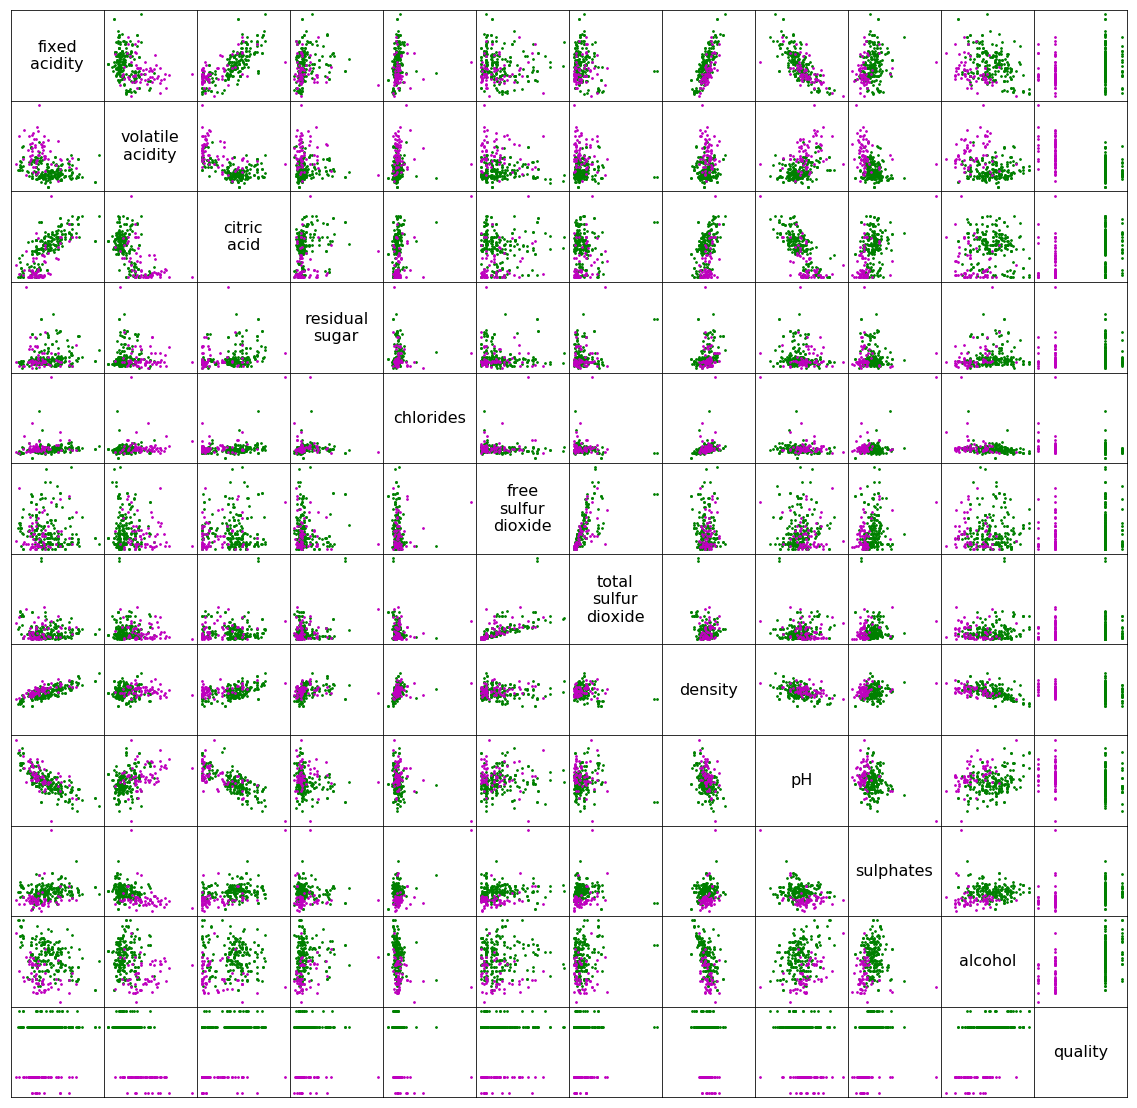

In [242]:
plot_scatter_matrix(red_wine_df, 6, 5)

#### b) Which factors do you think will be most useful for distinguishing high vs low quality wines

At a first glance I see that sulphates and alcohol have a clearer division when it comes to quality.
We can see in the figure that in most cases a higher alcohol quantity and a higher level of sulphates results
in a beter quality wine. This is the case when comparing high quality wines (8 or higher) vs low quality wines
(3 or lower)

### V.2 Learning to perceptron

#### a) & b) Perceptron implementation and training

In [5]:
def heaviside_step_fn(nb):
    if (nb < 0):
        return (0)
    elif (nb >= 0):
        return (1)

def dot_prod(v1, v2):
    return (sum([x * y for x, y in zip(v1, v2)]))

def vec_add(v1, v2):
    return ([round(x + y, 2) for x, y in zip(v1, v2)])
    
def vec_sub(v1, v2):
    return ([round(x - y, 2) for x, y in zip(v1, v2)])

def vec_scale(v, scalar):
    return ([i * scalar for i in v])

def select_features_labels(wine_data, good_quality_nb, bad_quality_nb):
    tmp = wine_data[['pH', 'alcohol', 'quality']][(
        wine_data['quality'] > good_quality_nb) | (wine_data['quality'] < bad_quality_nb)]
    tmp['quality'].where(tmp['quality'] < bad_quality_nb, 1, inplace=True) # Replace good_quality_nb and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and bad quality and below with 0
    features = tmp[['pH', 'alcohol']]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

def update_weights(w, x, y, l_rate):
    update = False
    if (heaviside_step_fn(dot_prod(w, x)) == 1 and y == 0):
        update = True
        w = vec_sub(w, vec_scale(x, l_rate)) # w = w - lr * x
    elif (heaviside_step_fn(dot_prod(w, x)) == 0 and y == 1):
        update = True
        w = vec_add(w, vec_scale(x, l_rate)) # w = w + lr * x
    return (w, update)
    
def perceptron_trainer(wine_data, l_rate, epochs):
    features, labels = select_features_labels(wine_data, 7, 4)
    train_until_convergence = False
    epoch_count = 0
    info = []
    if (epochs == 0):
        train_until_convergence = True # train until convergence if epochs is 0
        epochs = 1 # epoch_count < epochs so it enters the loop
    converged = False
    w = [0, 0, 0] # w[0] is the bias
    for i in range(3):
        w[i] = round(random.uniform(-1, 1), 2) # init random weights between -1 and 1
    while (not converged and epoch_count < epochs):
        converged = True
        errors_at_epoch = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            w, update = update_weights(w, x, y, l_rate)
            if (update == True): # if there was no update in the whole dataset that means our model has converged
                converged = False
                errors_at_epoch += 1
        info.append((epoch_count, errors_at_epoch, w))
        epoch_count += 1
        if (train_until_convergence == True):
            epochs = epoch_count + 1 # we don't want to stop training until convergence
    return (info)

In [6]:
random.seed(1998)
performance = perceptron_trainer(red_wine_df, l_rate=0.98, epochs=0)

#### c) Plot perceptron performance

In [7]:
def plot_perceptron_performance(wine_data, performance, good_threshold, bad_threshold, epoch=-1):
    fig, axvec = plt.subplots(1, 2, figsize=(15, 5))
    if (epoch >= 0):
        performance = performance[: epoch + 1]
    else:
        epoch = performance[-1][0]
    df = pd.DataFrame(performance)
    
    plt.sca(axvec[0])
    plt.plot(df[0], df[1])
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Error as a function of epoch')
    
    plt.sca(axvec[1])
    good = plt.scatter(wine_data['pH'][wine_data['quality'] > good_threshold],
                wine_data['alcohol'][wine_data['quality'] > good_threshold], s=15, c='g')
    bad = plt.scatter(wine_data['pH'][wine_data['quality'] < bad_threshold],
                wine_data['alcohol'][wine_data['quality'] < bad_threshold], s=15, c='m')
    plt.legend((good, bad), ('good wines (> {} score)'.format(good_threshold),
                             'bad wines (< {} score)'.format(bad_threshold)), loc=(1.01, 0.88))
    plt.xlabel('pH')
    plt.ylabel('alcohol')
    plt.title('Decision boundary on epoch {}'.format(epoch))
    x_list = [2.8, 3.8]
    w = performance[-1][2]
    #w[0] /= 250
    #w[1] /= 250
    #w[2] /= 250
    print(w)
    x_intercept = -w[0] / w[1]
    y_intercept = -w[0] / w[2]
    # m = (y2 - y1) / (x2 - x1)
    m = -y_intercept / x_intercept
    # y = mx + b
    y = [0, 0]
    y[0] = m * x_list[0] + w[0]
    y[1] = m * x_list[1] + w[0]
    #y = (-1 * w[1] / w[2]) * x_list + (-1 * w[0] / w[2]) # this is just math. source: https://medium.com/@thomascountz/calculate-the-decision-boundary-of-a-single-perceptron-visualizing-linear-separability-c4d77099ef38
    #plt.plot(x_list, y)
    
    plt.show()

[478.42, -646.82, 161.1]


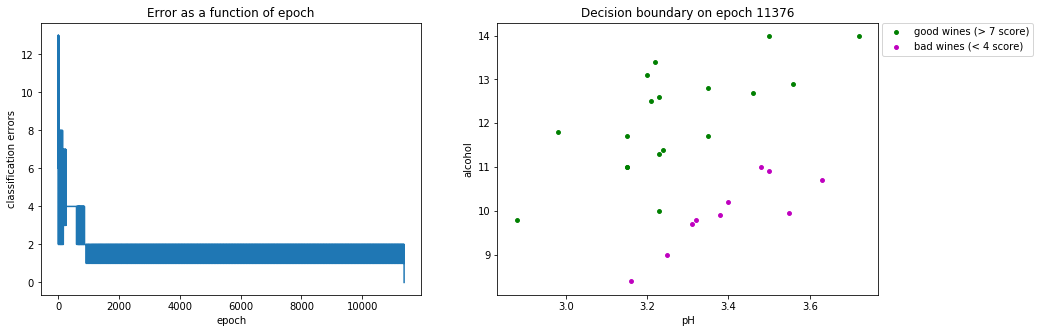

In [8]:
plot_perceptron_performance(red_wine_df, performance, 7, 4)

#### d) Feature scaling for faster training

In [9]:
def normalize_data(wine_data):
    quality = wine_data["quality"]
    norm_wine_data = wine_data.drop(labels="quality", axis='columns')
    norm_wine_data = (norm_wine_data - norm_wine_data.mean()) / (norm_wine_data.max() - norm_wine_data.min())
    norm_wine_data["quality"] = quality
    return (norm_wine_data)

[0.18, -4.24, 4.29]


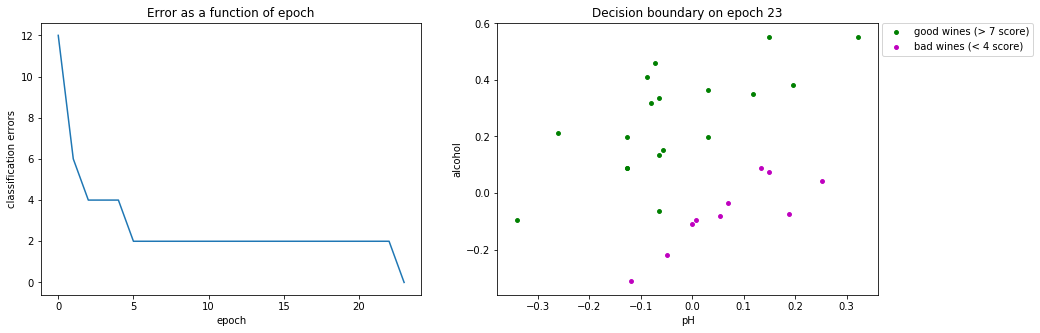

In [10]:
random.seed(1998)
norm_red_wine_df = normalize_data(red_wine_df)
norm_perf = perceptron_trainer(norm_red_wine_df, l_rate=0.98, epochs=0)
plot_perceptron_performance(norm_red_wine_df, norm_perf, 7, 4)

### V.3 My fair ADALINE

#### a)&b)&c) Implement an ADALINE with gradient descent and a training function

In [116]:
class Adaline:
    def __init__(self):
        self.weights = [0, 0, 0]
        for i in range(3):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def test(self, features, labels):
        error_count = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[0][i:i + batch_size], features[1][i:i + batch_size], labels[i:i + batch_size]
    def batch_processing(self, features, labels, l_rate, batch_size):
        generator = self.next_batch(features, labels, batch_size)
        for batch_x1, batch_x2, batch_y in generator:
            batch_error = 0
            batch_gradient = [0, 0, 0]
            for x1, x2, y in zip(batch_x1, batch_x2, batch_y):
                x = [1, x1, x2]
                error = y - dot_prod(self.weights, x)
                gradient = vec_scale(v=x, scalar=2 * l_rate * error)
                batch_error += error
                batch_gradient = vec_add(batch_gradient, gradient)
            batch_error /= len(batch_x1)
            self.weights = vec_add(self.weights, batch_gradient)
    def train(self, wine_data, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels(wine_data, good_nb, bad_nb)
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            self.batch_processing(features, labels, l_rate, batch_size)
            errors_at_epoch = self.test(features, labels)
            if (errors_at_epoch > 0):
                if (errors_at_epoch >= errors_at_prev_epoch):
                    count += 1
                else:
                    count = 0
                if (count < 1000):
                    converged = False
            errors_at_prev_epoch = errors_at_epoch
            epoch_count += 1
            info.append((epoch_count, errors_at_epoch, self.weights))
            if (train_until_convergence == True):
                epochs = epoch_count + 1
        return (info)

#### d) Finding good hyperparameters for my ADALINE

In [ ]:
random.seed(1998)
good_threshold = 7
bad_threshold = 4
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.03, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.0003, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
features, labels = select_features_labels(red_wine_df, good_threshold, bad_threshold)

In [ ]:
print(len(features[0]), "                  ", len(features[1]))
print("***************************")
count = 0
for i, j, k in zip(features[0], features[1], labels):
    print("{:>5} {:>5} {:>5}".format(i, j, k))
    count += 1
    if (count % 10 == 0):
        print("----------------------------")

[0.18, -0.76, 0.27]


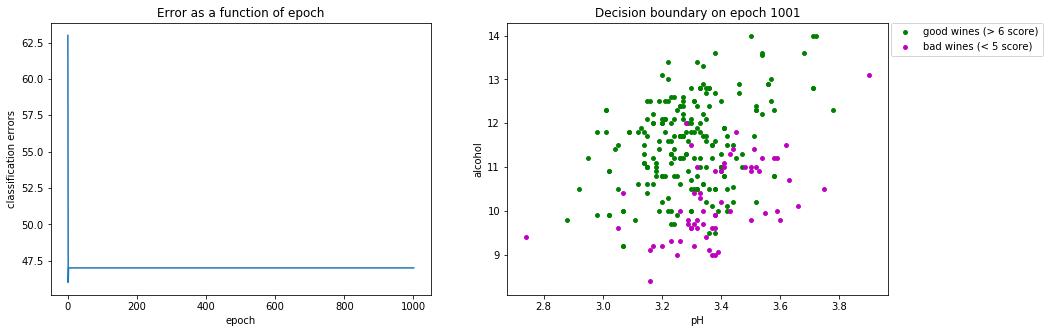

In [12]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df,
                        l_rate=0.0002,
                        batch_size=32,
                        epochs=0,
                        good_nb=good_threshold,
                        bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

### V.4 Advanced wine sampling and resampling

#### a) Holdout method to partition data in training and validation

In [13]:
def partition_data(wine_data, validation_split):
    wine_data = wine_data.sample(frac=1).reset_index(drop=True) # shuffle data
    size = len(wine_data)
    validation_size = round(size * validation_split)
    training_size = size - validation_size
    return (wine_data.head(training_size), wine_data.tail(validation_size))

#### b) k-fold cross-validation dataset

In [48]:
pd.set_option('display.max_rows', 2000)
def k_fold_validation(wine_data, k, shuffle=True):
    if (shuffle == True):
        wine_data = wine_data.sample(frac=1).reset_index(drop=True)
    k_size = round(len(wine_data) / k)
    k_folds = []
    for i in range(0, len(wine_data), k_size):
        k_folds.append(wine_data[i:i + k_size])
    k_tuples = []
    for i in range(k):
        training = pd.DataFrame()
        for j in range(k):
            if (i != j):
                training = pd.concat((training, k_folds[j]))
        k_tuples.append((training, k_folds[i]))
    return (k_tuples)

#### c) Effects on changing learning rate and epochs: k-fold cross-validation

In [224]:
def adaline_k_fold_validation(wine_data, l_rate, k, shuffle=True,
                              batch_size=1, epochs=0, good_nb=6, bad_nb=5):
    if (epochs == 0):
        return(print("epochs can't be 0"))
    tmp = wine_data[['pH', 'alcohol', 'quality']][(
        wine_data['quality'] > good_nb) | (wine_data['quality'] < bad_nb)]
    tmp['quality'].where(tmp['quality'] < bad_nb, 1, inplace=True) # Replace above good_quality_nb with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and below bad_quality_nb 0
    k_folds = k_fold_validation(tmp, k, shuffle=shuffle)
    my_adaline = Adaline()
    
    errors = 0
    val_errors = 0
    for fold in k_folds:
        features, labels = select_features_labels(fold[0], good_nb, bad_nb)
        val_features, val_labels = select_features_labels(fold[1], good_nb, bad_nb)
        e = my_adaline.test(features, labels)
        val_e = my_adaline.test(val_features, val_labels)
        errors += e
        val_errors += val_e
    errors /= len(k_folds)
    val_errors /= len(k_folds)
    print("epoch 0: average training     errors: {:<4}/{:<4} => {:<2}%".format(errors, len(labels), round(errors / len(labels) * 100, 2)))
    print("         average validation   errors: {:<4}/{:<4} => {:<2}%".format(val_errors, len(val_labels), round(val_errors / len(val_labels) * 100, 2)))
    print("weights learned", my_adaline.weights)
    print()
    
    for epoch in range(epochs):
        errors = 0
        val_errors = 0
        for fold in k_folds:
            features, labels = select_features_labels(fold[0], good_nb, bad_nb)
            val_features, val_labels = select_features_labels(fold[1], good_nb, bad_nb)
            my_adaline.train(fold[0], l_rate=l_rate, batch_size=batch_size,
                             epochs=1, good_nb=good_nb, bad_nb=bad_nb)
            e = my_adaline.test(features, labels)
            val_e = my_adaline.test(val_features, val_labels)
            errors += e
            val_errors += val_e
        errors /= len(k_folds)
        val_errors /= len(k_folds)
        print("epoch {}: average training     errors: {:<4}/{:<4} => {:<2}%".format(epoch + 1, errors, len(labels), round(errors / len(labels) * 100, 2)))
        print("         average validation   errors: {:<4}/{:<4} => {:<2}%".format(val_errors, len(val_labels), round(val_errors / len(val_labels) * 100, 2)))
        print("weights learned", my_adaline.weights)
        print()

In [237]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.003, k=10, epochs=3, shuffle=False)

epoch 0: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.19]

epoch 1: average training     errors: 46.2/252  => 18.33%
         average validation   errors: 5.3 /28   => 18.93%
weights learned [-0.3, -0.29, 0.19]

epoch 2: average training     errors: 54.4/252  => 21.59%
         average validation   errors: 6.1 /28   => 21.79%
weights learned [0.34, -0.48, 0.19]

epoch 3: average training     errors: 53.9/252  => 21.39%
         average validation   errors: 5.7 /28   => 20.36%
weights learned [0.79, -0.58, 0.18]



In [238]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.003, k=10, epochs=10, shuffle=False)

epoch 0: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.19]

epoch 1: average training     errors: 46.2/252  => 18.33%
         average validation   errors: 5.3 /28   => 18.93%
weights learned [-0.3, -0.29, 0.19]

epoch 2: average training     errors: 54.4/252  => 21.59%
         average validation   errors: 6.1 /28   => 21.79%
weights learned [0.34, -0.48, 0.19]

epoch 3: average training     errors: 53.9/252  => 21.39%
         average validation   errors: 5.7 /28   => 20.36%
weights learned [0.79, -0.58, 0.18]

epoch 4: average training     errors: 55.6/252  => 22.06%
         average validation   errors: 6.1 /28   => 21.79%
weights learned [1.09, -0.61, 0.16]

epoch 5: average training     errors: 56.7/252  => 22.5%
         average validation   errors: 6.3 /28   => 22.5%
weights learned [1.27, -0.53, 0.12]

epoch 6: average training     errors: 56.5/252  => 22.42%
         average validatio

In [239]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.00003, k=10, epochs=10, shuffle=False)

epoch 0: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.19]

epoch 1: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.06]

epoch 2: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.06]

epoch 3: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.06]

epoch 4: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.06]

epoch 5: average training     errors: 195.3/252  => 77.5%
         average validation   errors: 21.7/28   => 77.5%
weights learned [-0.9, -0.83, -0.06]

epoch 6: average training     errors: 195.3/252  => 77.5%
         average validat

### V.5 Adventures in the Nth dimension

In [245]:
red_wine_df.columns.values

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [ ]:
def select_features_labels(wine_data, good_quality_nb, bad_quality_nb):
    tmp = wine_data[['pH', 'alcohol', 'sulphates', 'quality']][(
        wine_data['quality'] > good_quality_nb) | (wine_data['quality'] < bad_quality_nb)]
    tmp['quality'].where(tmp['quality'] < bad_quality_nb, 1, inplace=True) # Replace good_quality_nb and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and bad quality and below with 0
    features = tmp[['pH', 'alcohol']]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

class Adaline_2:
    def __init__(self, input_size):
        self.weights = [0] * input_size
        for i in range(input_size):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def test(self, features, labels):
        error_count = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[0][i:i + batch_size], features[1][i:i + batch_size], labels[i:i + batch_size]
    def batch_processing(self, features, labels, l_rate, batch_size):
        generator = self.next_batch(features, labels, batch_size)
        for batch_x1, batch_x2, batch_y in generator:
            batch_error = 0
            batch_gradient = [0, 0, 0]
            for x1, x2, y in zip(batch_x1, batch_x2, batch_y):
                x = [1, x1, x2]
                error = y - dot_prod(self.weights, x)
                gradient = vec_scale(v=x, scalar=2 * l_rate * error)
                batch_error += error
                batch_gradient = vec_add(batch_gradient, gradient)
            batch_error /= len(batch_x1)
            self.weights = vec_add(self.weights, batch_gradient)
    def train(self, wine_data, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels(wine_data, good_nb, bad_nb)
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            self.batch_processing(features, labels, l_rate, batch_size)
            errors_at_epoch = self.test(features, labels)
            if (errors_at_epoch > 0):
                if (errors_at_epoch >= errors_at_prev_epoch):
                    count += 1
                else:
                    count = 0
                if (count < 1000):
                    converged = False
            errors_at_prev_epoch = errors_at_epoch
            epoch_count += 1
            info.append((epoch_count, errors_at_epoch, self.weights))
            if (train_until_convergence == True):
                epochs = epoch_count + 1
        return (info)